<h1><strong><u>Logistic Regression Test</u></strong><h1>

In [17]:
import matplotlib.pyplot as plt            
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, learning_curve, validation_curve
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, PrecisionRecallDisplay, accuracy_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbLearn_Pipeline

<h2><strong><u>Data Preparation</u></strong></h2>

In [18]:
pd.read_csv("./SMSSpamCollection.txt", sep="\t", header=None).to_csv("sms_spam_collection.csv", index=False, header=["target", "message"])

In [19]:
data = pd.read_csv("sms_spam_collection.csv")
data

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [20]:
X = data['message']
y = data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
display(X_train.shape) 
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(4457,)

(1115,)

(4457,)

(1115,)

In [21]:
#Display message counts
hams = data[(data['target'] == 'ham')]
spams = data[(data['target'] == 'spam')]
hams_count = hams.value_counts().sum()
spams_count = spams.value_counts().sum()
total_messages = hams_count + spams_count
spam_fraction = spams_count / total_messages

print("Number of ham messages: ", hams_count)
print("Number of spam messages: ", spams_count)
print("Fraction of spam messages: {:.2f}%".format(spam_fraction * 100))

Number of ham messages:  4825
Number of spam messages:  747
Fraction of spam messages: 13.41%


In [22]:
def custom_tokenizer(text):
        from nltk.tokenize import word_tokenize
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        import re
        en_stopwords = stopwords.words('english')
        lemmatizer = WordNetLemmatizer()
        new_text = text.lower() #lowercase

        new_text = re.sub(r"([^\w\s])", "", new_text) #remove punctuation

        for word in new_text.split(): #remove stopwords
            if word in en_stopwords:
                new_text = new_text.replace(word, "")
        
        new_text = word_tokenize(new_text) #tokenize

        new_text = [lemmatizer.lemmatize(token) for token in new_text] #lemmatize
        return new_text

In [23]:
custom_f1_scorer_spam = make_scorer(f1_score, greater_is_better=True, pos_label='spam')
custom_f1_scorer_ham = make_scorer(f1_score, greater_is_better=True, pos_label='ham')

<h2><strong><u>Logistic Regression Model Selection</u></strong><h2>

<h3><strong><u>Validation Curve Test</u></strong></h3>

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ......................................clf__C=0.0001; total time=   1.0s
[CV] END ...........................................clf__C=1; total time=   0.9s
[CV] END .........................................clf__C=0.1; total time=   1.0s
[CV] END ..........................................clf__C=10; total time=   0.9s
[CV] END ........................................clf__C=0.01; total time=   1.0s
[CV] END .......................................clf__C=0.001; total time=   1.0s
[CV] END .......................................clf__C=0.001; total time=   0.9s
[CV] END ......................................clf__C=0.0001; total time=   1.0s
[CV] END ..........................................clf__C=10; total time=   0.8s
[CV] END ......................................clf__C=0.0001; total time=   1.0s
[CV] END ........................................clf__C=0.01; total time=   1.0s
[CV] END ...........................................clf__C=1; total time=   1.0s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    3.7s remaining:    3.7s


[CV] END .......................................clf__C=0.001; total time=   0.8s
[CV] END ......................................clf__C=0.0001; total time=   0.8s
[CV] END ..........................................clf__C=10; total time=   0.8s
[CV] END ...........................................clf__C=1; total time=   0.8s
[CV] END ........................................clf__C=0.01; total time=   0.8s
[CV] END .........................................clf__C=0.1; total time=   0.8s
[CV] END ...........................................clf__C=1; total time=   0.8s
[CV] END ..........................................clf__C=10; total time=   0.7s
[CV] END .......................................clf__C=0.001; total time=   0.5s
[CV] END ......................................clf__C=0.0001; total time=   0.5s
[CV] END ........................................clf__C=0.01; total time=   0.5s
[CV] END .........................................clf__C=0.1; total time=   0.5s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


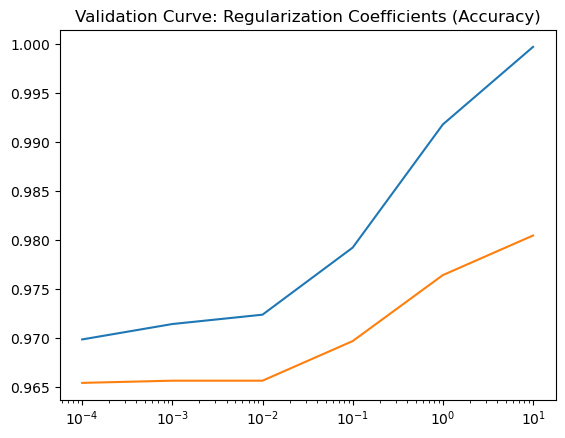

In [24]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("samp", SMOTE(random_state=2)),
        ("clf", LogisticRegression())
    ]
) 

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__C",
                                                   param_range=alphas,
                                                   verbose=2,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.title("Validation Curve: Regularization Coefficients (Accuracy)")
plt.semilogx(alphas, train_scores_mean)
plt.semilogx(alphas, validation_scores_mean)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ......................................clf__C=0.0001; total time=   0.6s
[CV] END .......................................clf__C=0.001; total time=   0.6s
[CV] END .......................................clf__C=0.001; total time=   0.7s
[CV] END ..........................................clf__C=10; total time=   0.6s
[CV] END .........................................clf__C=0.1; total time=   0.6s
[CV] END ........................................clf__C=0.01; total time=   0.6s
[CV] END ...........................................clf__C=1; total time=   0.7s
[CV] END ......................................clf__C=0.0001; total time=   0.6s
[CV] END ........................................clf__C=0.01; total time=   0.7s
[CV] END .........................................clf__C=0.1; total time=   0.7s
[CV] END .......................................clf__C=0.001; total time=   0.6s
[CV] END ...........................................clf__C=1; total time=   0.7s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    2.3s remaining:    2.3s


[CV] END ...........................................clf__C=1; total time=   0.6s
[CV] END ......................................clf__C=0.0001; total time=   0.6s
[CV] END ........................................clf__C=0.01; total time=   0.6s
[CV] END ...........................................clf__C=1; total time=   0.6s
[CV] END .......................................clf__C=0.001; total time=   0.7s
[CV] END ..........................................clf__C=10; total time=   0.6s
[CV] END ..........................................clf__C=10; total time=   0.7s
[CV] END .........................................clf__C=0.1; total time=   0.6s
[CV] END .......................................clf__C=0.001; total time=   0.5s
[CV] END ........................................clf__C=0.01; total time=   0.5s
[CV] END ......................................clf__C=0.0001; total time=   0.6s
[CV] END ...........................................clf__C=1; total time=   0.5s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.4s finished


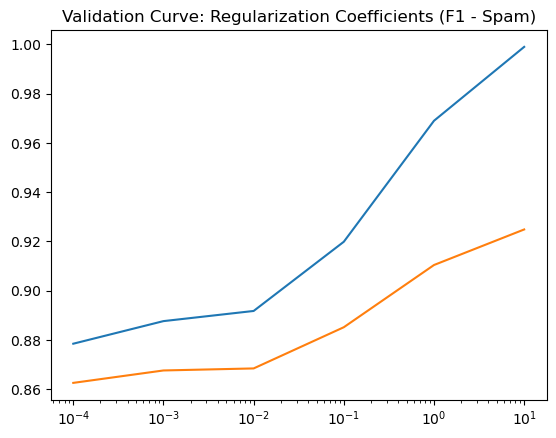

In [25]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("samp", SMOTE(random_state=2)),
        ("clf", LogisticRegression())
    ]
) 

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring=custom_f1_scorer_spam,
                                                   param_name="clf__C",
                                                   param_range=alphas,
                                                   verbose=2,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.title("Validation Curve: Regularization Coefficients (F1 - Spam)")
plt.semilogx(alphas, train_scores_mean)
plt.semilogx(alphas, validation_scores_mean)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ......................................clf__C=0.0001; total time=   2.6s
[CV] END .......................................clf__C=0.001; total time=   2.6s
[CV] END ........................................clf__C=0.01; total time=   2.7s
[CV] END ..........................................clf__C=10; total time=   2.7s
[CV] END ...........................................clf__C=1; total time=   2.8s
[CV] END ......................................clf__C=0.0001; total time=   2.8s
[CV] END .......................................clf__C=0.001; total time=   2.9s
[CV] END .........................................clf__C=0.1; total time=   2.8s
[CV] END ........................................clf__C=0.01; total time=   0.8s
[CV] END .......................................clf__C=0.001; total time=   0.7s
[CV] END .........................................clf__C=0.1; total time=   0.8s
[CV] END ..........................................clf__C=10; total time=   0.8s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    8.4s remaining:    8.4s


[CV] END ........................................clf__C=0.01; total time=   0.8s
[CV] END .......................................clf__C=0.001; total time=   0.8s
[CV] END ..........................................clf__C=10; total time=   0.9s
[CV] END ......................................clf__C=0.0001; total time=   0.8s
[CV] END .........................................clf__C=0.1; total time=   0.8s
[CV] END ...........................................clf__C=1; total time=   0.9s
[CV] END ...........................................clf__C=1; total time=   0.7s
[CV] END ..........................................clf__C=10; total time=   0.8s
[CV] END ......................................clf__C=0.0001; total time=   0.6s
[CV] END .......................................clf__C=0.001; total time=   0.6s
[CV] END ........................................clf__C=0.01; total time=   0.6s
[CV] END ..........................................clf__C=10; total time=   0.5s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.6s finished


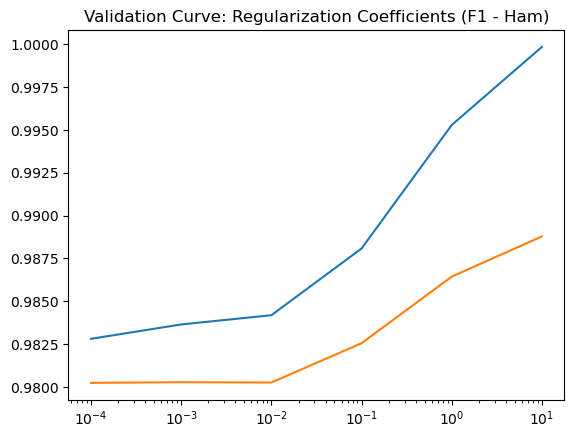

In [27]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("samp", SMOTE(random_state=2)),
        ("clf", LogisticRegression())
    ]
) 

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring=custom_f1_scorer_ham,
                                                   param_name="clf__C",
                                                   param_range=alphas,
                                                   verbose=2,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.title("Validation Curve: Regularization Coefficients (F1 - Ham)")
plt.semilogx(alphas, train_scores_mean)
plt.semilogx(alphas, validation_scores_mean)

<h4><u>Findings From Validation Curve Test</u></h4>
Switching between the RandomUnderSampler function and SMOTE while using a logarithmic range of regularization coefficients, I found that SMOTE performed better than the RandomUnderSampling function. Also, I saw that a low regularization coefficient range (1-10) will yield a better train/validation split than a high regularization coefficient range.

<h3><strong><u>Cross-Validation Test</u></strong></h3>

In [16]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("samp", SMOTE(random_state=2)),
        ("clf", LogisticRegression())
    ]
) 
param_grid = {"clf__C": [0.1, 0.3, 0.5, 0.7, 0.9, 1]}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring=custom_f1_scorer_spam, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
log_model = grid_search.best_estimator_
print(log_model)

def logistic_cv():
    return log_model

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .........................................clf__C=0.1; total time=   0.7s
[CV] END .........................................clf__C=0.1; total time=   0.7s
[CV] END .........................................clf__C=0.1; total time=   0.8s
[CV] END .........................................clf__C=0.1; total time=   0.8s
[CV] END .........................................clf__C=0.3; total time=   0.7s
[CV] END .........................................clf__C=0.3; total time=   0.7s
[CV] END .........................................clf__C=0.1; total time=   0.8s
[CV] END .........................................clf__C=0.3; total time=   0.7s
[CV] END .........................................clf__C=0.3; total time=   0.6s
[CV] END .........................................clf__C=0.3; total time=   0.6s
[CV] END .........................................clf__C=0.5; total time=   0.6s
[CV] END ........................................

<h4><strong><u>Findings From 'Model Selection' Section</u></strong></h4>
The scoring metrics that I used for the Grid Search cross-validation test was the f1 score with 'spam' as the positive class. F1 score is a good method to access the model's performance especially for imbalanced dataset or even datasets that have been synthetically balanced like this one. Switching between the RandomUnderSampler function and SMOTE while using a logarithmic range of regularization coefficients, I found that SMOTE performed better than the RandomUnderSampling function on the f1 scores. For the regularization coefficient, I found that the best regularization coefficient will mostly likely be 0.1. Therefore, I used a small range of regularization coefficients that included 0.1, along with SMOTE in a pipeline for the Grid Search cross-validation test. As expected, after running the cross-validation test, I found that the best value for alpha was 0.1.

<h2><strong><u>Model Evaluation</u></strong></h2>

<h3><strong><u>Learning Curve Tests</u></strong></h3>

In [ ]:
clf_metrics = {'F1 (Spam)': custom_f1_scorer_spam, 'F1 (Ham)': custom_f1_scorer_ham}

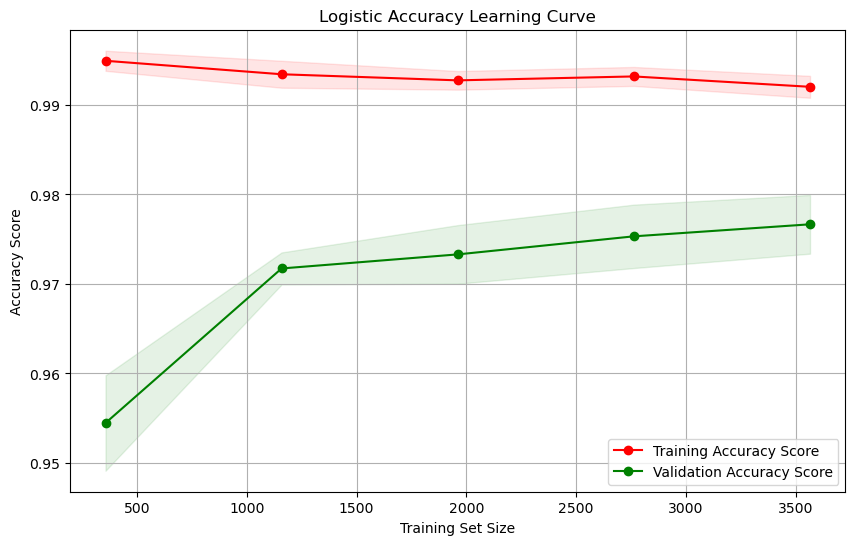

In [24]:
logistic_train_sizes, logistic_train_scores, logistic_validation_scores = learning_curve(
    log_model,
    X_train,
    y_train,
    cv=5,  # Number of folds for cross-validation
    scoring='accuracy',  # Metric to evaluate the model
    n_jobs=-1,  # Use all available CPU cores
)

# Calculate mean and standard deviation for scores
logistic_train_scores_mean = np.mean(logistic_train_scores, axis=1)
logistic_train_scores_std = np.std(logistic_train_scores, axis=1)
logistic_validation_scores_mean = np.mean(logistic_validation_scores, axis=1)
logistic_validation_scores_std = np.std(logistic_validation_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title(f"Logistic Accuracy Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel(f"Accuracy Score")
plt.grid()

plt.fill_between(logistic_train_sizes, logistic_train_scores_mean - logistic_train_scores_std,
                logistic_train_scores_mean + logistic_train_scores_std, alpha=0.1,
                color="r")
plt.fill_between(logistic_train_sizes, logistic_validation_scores_mean - logistic_validation_scores_std,
                logistic_validation_scores_mean + logistic_validation_scores_std, alpha=0.1,
                color="g")
plt.plot(logistic_train_sizes, logistic_train_scores_mean, 'o-', color="r",
            label=f"Training Accuracy Score")
plt.plot(logistic_train_sizes, logistic_validation_scores_mean, 'o-', color="g",
            label=f"Validation Accuracy Score")

plt.legend(loc="best")
plt.show()

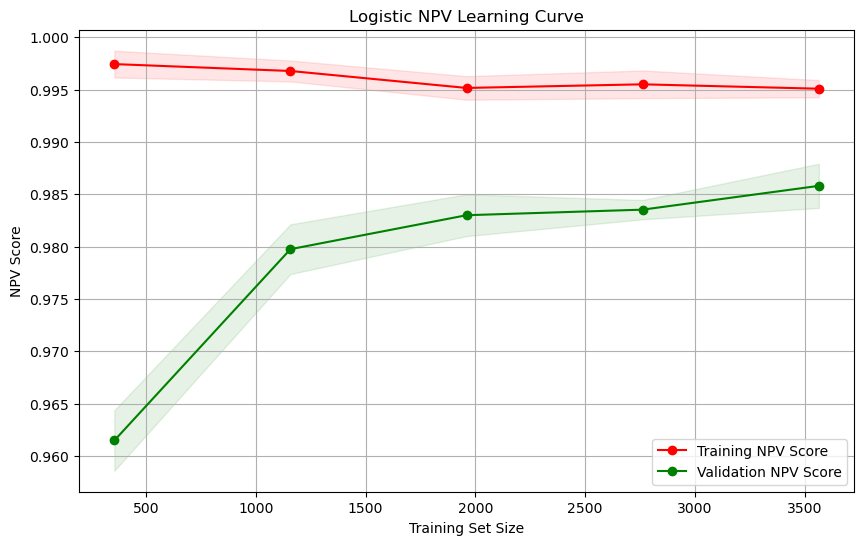

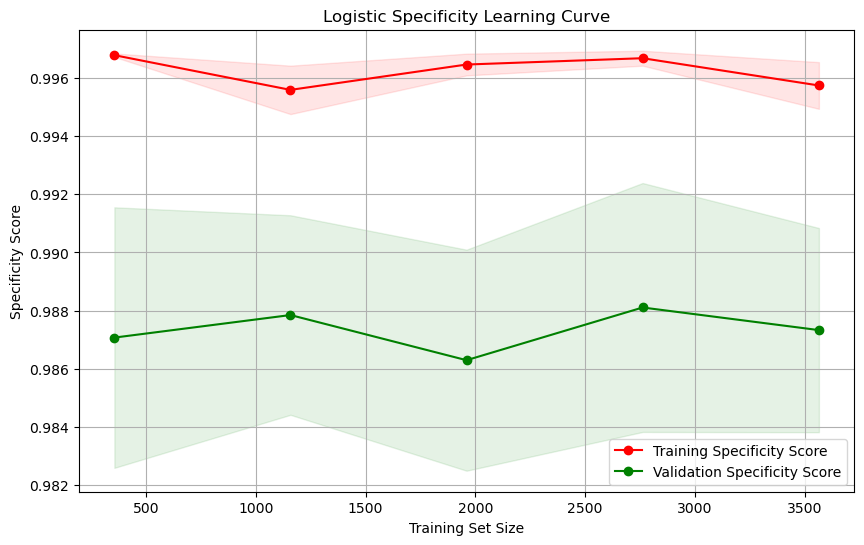

Exception ignored in: <function ResourceTracker.__del__ at 0x1022f1bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10309dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106569bc0>
Traceback (most recent call last

In [ ]:
for key, value in clf_metrics.items():
    logistic_train_sizes, logistic_train_scores, logistic_validation_scores = learning_curve(
        log_model,
        X_train,
        y_train,
        cv=5,  # Number of folds for cross-validation
        scoring=value,  # Metric to evaluate the model
        n_jobs=-1,  # Use all available CPU cores
    )

    # Calculate mean and standard deviation for scores
    logistic_train_scores_mean = np.mean(logistic_train_scores, axis=1)
    logistic_train_scores_std = np.std(logistic_train_scores, axis=1)
    logistic_validation_scores_mean = np.mean(logistic_validation_scores, axis=1)
    logistic_validation_scores_std = np.std(logistic_validation_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.title(f"Logistic {key} Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel(f"{key} Score")
    plt.grid()

    plt.fill_between(logistic_train_sizes, logistic_train_scores_mean - logistic_train_scores_std,
                    logistic_train_scores_mean + logistic_train_scores_std, alpha=0.1,
                    color="r")
    plt.fill_between(logistic_train_sizes, logistic_validation_scores_mean - logistic_validation_scores_std,
                    logistic_validation_scores_mean + logistic_validation_scores_std, alpha=0.1,
                    color="g")
    plt.plot(logistic_train_sizes, logistic_train_scores_mean, 'o-', color="r",
                label=f"Training {key} Score")
    plt.plot(logistic_train_sizes, logistic_validation_scores_mean, 'o-', color="g",
                label=f"Validation {key} Score")

    plt.legend(loc="best")
    plt.show()

<h4><u>Findings From Learning Curve Test</u></h4>
After applying CV test to the 0.1-1 regularization coefficient range, all five classifier metrics resulted in C=1. After displaying the learning curves for these five metrics, I am going to continue with C=1 because it has less of a probability of overfitting but still performs well on the classifier metrics.

<h2><strong><u>Metrics</u></strong></h2>

<h3><u>Training Metrics<u></h3>

In [46]:
#Cross-Validation Loop
print("Accuracy")
log_training_values = cross_val_score(log_model, X_train, y_train, scoring='accuracy', cv=5)
print("CV Training Scores: ", log_training_values)
np_log_training_values = np.array(log_training_values)
average = np.mean(np_log_training_values)
stDev = np.std(np_log_training_values)
print("Average and Standard Error: {:.2f}%".format(average.round(2)), "\u00B1", "{:.2f}%".format(stDev.round(4)*100), "\n")

Accuracy
CV Training Scores:  [0.97309417 0.98206278 0.97418631 0.97979798 0.97306397]
Average and Standard Error: 0.98% ± 0.38% 



In [47]:
for key in clf_metrics:
    print(f"{key}")
    log_training_values = cross_val_score(log_model, X_train, y=y_train_transformed, scoring=key, cv=5)
    print(f"CV Training Scores: ", log_training_values)
    np_log_training_values = np.array(log_training_values)
    average = np.mean(np_log_training_values)
    stDev = np.std(np_log_training_values)
    print(f"Average and Standard Error: ", "{:.2f}%".format(average.round(2)), "\u00B1", "{:.2f}%".format(stDev.round(4)*100), "\n")

precision
CV Training Scores:  [0.8852459  0.93965517 0.92727273 0.93859649 0.89166667]
Average and Standard Error:  0.92% ± 2.34% 

recall
CV Training Scores:  [0.91525424 0.92372881 0.87179487 0.90677966 0.90677966]
Average and Standard Error:  0.90% ± 1.77% 



In [48]:
for key, value in clf_metrics.items():
    print(f"{value}")
    log_training_values = cross_val_score(log_model, X_train, y=y_train_transformed_rev, scoring=key, cv=5)
    print(f"CV Training Scores: ", log_training_values)
    np_log_training_values = np.array(log_training_values)
    average = np.mean(np_log_training_values)
    stDev = np.std(np_log_training_values)
    print(f"Average and Standard Error: ", "{:.2f}%".format(average.round(2)), "\u00B1", "{:.2f}%".format(stDev.round(4)*100), "\n")

NPV
CV Training Scores:  [0.98701299 0.98840206 0.98079385 0.98584299 0.98573281]
Average and Standard Error:  0.99% ± 0.26% 

Specificity
CV Training Scores:  [0.98191214 0.99095607 0.98966408 0.99094437 0.98318241]
Average and Standard Error:  0.99% ± 0.40% 



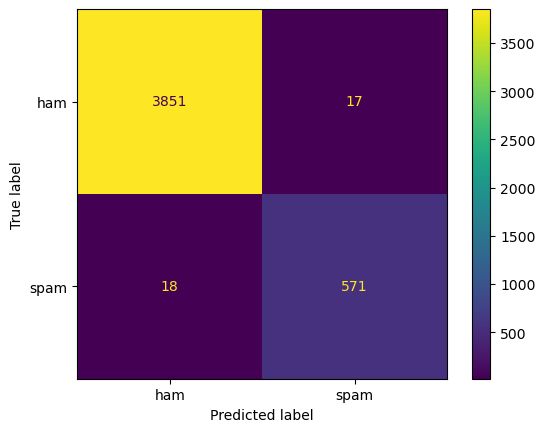

In [30]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(log_model, X_train, y_train)

In [31]:
train_predictions = log_model.predict(X_train)
log_train_precision = precision_score(y_train, train_predictions, pos_label='spam')
print("Logistic Training Precision: {:.2f}%".format(log_train_precision * 100))

log_train_recall = recall_score(y_train, train_predictions, pos_label='spam')
print("Logistic Training Recall: {:.2f}%".format(log_train_recall * 100))

log_train_npv = precision_score(y_train, train_predictions, pos_label='ham')
print("Logistic Negative Predictive Value Training Score: {:.2f}%".format(log_train_npv * 100))

log_train_specificity = recall_score(y_train, train_predictions, pos_label='ham')
print("Logistic Specificity Training Score: {:.2f}%".format(log_train_specificity * 100))

Logistic Training Precision: 97.11%
Logistic Training Recall: 96.94%
Logistic Negative Predictive Value Training Score: 99.53%
Logistic Specificity Training Score: 99.56%


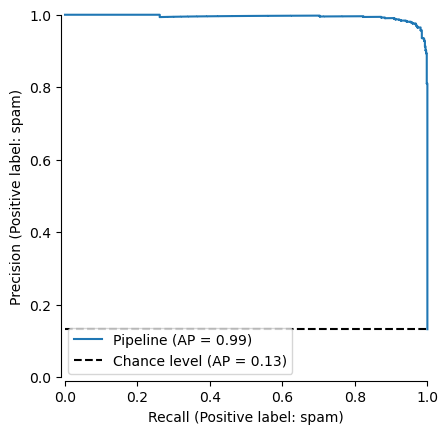

In [32]:
PrecisionRecallDisplay.from_estimator(log_model, X_train, y_train, pos_label="spam", plot_chance_level=True, despine=True)

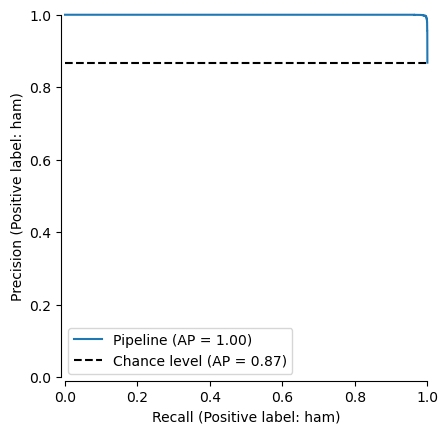

In [33]:
PrecisionRecallDisplay.from_estimator(log_model, X_train, y_train, pos_label="ham", plot_chance_level=True, despine=True)

<h3><u>Test Metrics</u></h3>

In [67]:
#Cross-Validation Loop
print("Accuracy")
log_test_values = cross_val_score(log_model, X_test, y_test, scoring='accuracy', cv=5)
print("CV test Scores: ", log_test_values)
np_log_test_values = np.array(log_test_values)
average = np.mean(np_log_test_values)
stDev = np.std(np_log_test_values)
print("Average and Standard Error: {:.2f}%".format(average.round(2)), "\u00B1", "{:.2f}%".format(stDev.round(4)*100), "\n")

Accuracy
CV test Scores:  [0.94618834 0.95964126 0.94170404 0.96860987 0.96860987]
Average and Standard Error: 0.96% ± 1.12% 



In [68]:
for key in clf_metrics:
    print(f"{key}")
    log_test_values = cross_val_score(log_model, X_test, y=y_test_transformed, scoring=key, cv=5)
    print(f"CV test Scores: ", log_test_values)
    np_log_test_values = np.array(log_test_values)
    average = np.mean(np_log_test_values)
    stDev = np.std(np_log_test_values)
    print(f"Average and Standard Error: ", "{:.2f}%".format(average.round(2)), "\u00B1", "{:.2f}%".format(stDev.round(4)*100), "\n")

precision
CV test Scores:  [0.85185185 0.84375    0.78787879 0.93103448 0.96296296]
Average and Standard Error:  0.88% ± 6.32% 

recall
CV test Scores:  [0.74193548 0.87096774 0.8125     0.84375    0.8125    ]
Average and Standard Error:  0.82% ± 4.31% 



In [69]:
for key, value in clf_metrics.items():
    print(f"{value}")
    log_test_values = cross_val_score(log_model, X_test, y=y_test_transformed_rev, scoring=key, cv=5)
    print(f"CV test Scores: ", log_test_values)
    np_log_test_values = np.array(log_test_values)
    average = np.mean(np_log_test_values)
    stDev = np.std(np_log_test_values)
    print(f"Average and Standard Error: ", "{:.2f}%".format(average.round(2)), "\u00B1", "{:.2f}%".format(stDev.round(4)*100), "\n")

NPV
CV test Scores:  [0.95918367 0.97905759 0.96842105 0.9742268  0.96938776]
Average and Standard Error:  0.97% ± 0.66% 

Specificity
CV test Scores:  [0.97916667 0.97395833 0.96335079 0.9895288  0.9947644 ]
Average and Standard Error:  0.98% ± 1.12% 



In [70]:
test_predictions = log_model.predict(X_test)

log_test_accuracy = accuracy_score(y_test, test_predictions)
print("Logistic Test Accuracy: {:.2f}%".format(log_test_accuracy * 100))

log_test_precision = precision_score(y_test, test_predictions, pos_label='spam')
print("Logistic Test Precision: {:.2f}%".format(log_test_precision * 100))

log_test_recall = recall_score(y_test, test_predictions, pos_label='spam')
print("Logistic Test Recall: {:.2f}%".format(log_test_recall * 100))

log_test_npv = precision_score(y_test, test_predictions, pos_label='ham')
print("Logistic Negative Predictive Value Test Score: {:.2f}%".format(log_test_npv * 100))

log_test_specificity = recall_score(y_test, test_predictions, pos_label='ham')
print("Logistic Specificity Test Score: {:.2f}%".format(log_test_specificity * 100))

Logistic Test Accuracy: 97.04%
Logistic Test Precision: 91.95%
Logistic Test Recall: 86.71%
Logistic Negative Predictive Value Test Score: 97.83%
Logistic Specificity Test Score: 98.75%


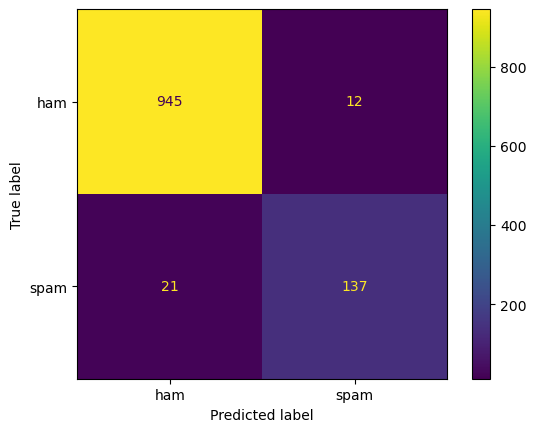

In [71]:
#Testing Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)

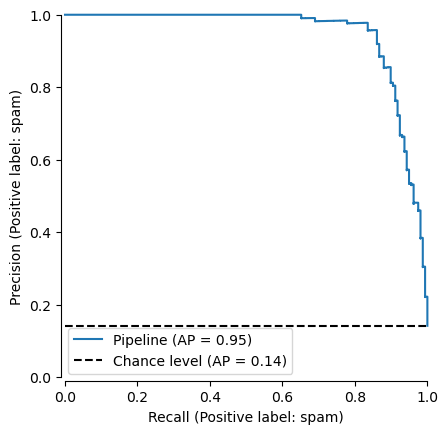

In [72]:
PrecisionRecallDisplay.from_estimator(log_model, X_test, y_test, pos_label="spam", plot_chance_level=True, despine=True)

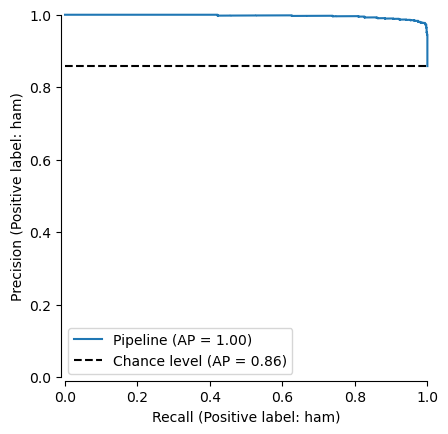

In [73]:
PrecisionRecallDisplay.from_estimator(log_model, X_test, y_test, pos_label="ham", plot_chance_level=True, despine=True)

<h4><strong><u>Findings From Metrics</u></strong></h4>

<h5><u>Training Metrics</u></h5>
I believe that the 'Training Metrics' section was a success. The best C-value for generalization was 1. The learning curves help validate that point. Also, the PrecisionRecallDisplay functions show good curves that move towards the top-right for both classes. Lastly, the cross-validation score function for all five metrics yielded good results with a good standard error for most of the metrics tested. The only exception would be precision and recall with a standard error of around 2% while others were around .4%. This is expected since both are 'positive-class metrics' and SMOTE was applied to the positive class imbalance. This can also explain why metrics pertaining to the negative class performed better than metrics pertaining to the positive class. 

<h5><u>Test Metrics</u></h5>
The 'Test Metrics' section was a success as well. As expected, precision and recall both yielded lower scores and higher standard errors than the other metrics but this is in keeping with the 'Training Metrics' section. As stated before, the dataset was lacking in positive cases but I still believe that the scores and the standard error for precision and recall are tolerable. Also, the PrecisionRecallDisplay functions yielded good curves for both classes.

<h2><strong><u>Final Thoughts</u></strong></h2>

Considering the results of the experiment, I believe this model can used for spam classification. One caveat to mention is that more actual positive cases would be needed to truly access how much predictive power this model holds.